**Setup**


First, let's fetch the Kaggle Dataset into Google Colab:

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samuelbenichou11","key":"0b0c4b51bd4dc5ddf32aa01ba1868f66"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change the permission 
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset
!kaggle datasets download -d hugomathien/soccer

 98% 32.0M/32.7M [00:00<00:00, 32.3MB/s]
100% 32.7M/32.7M [00:00<00:00, 55.4MB/s]


In [ ]:
from zipfile import *

file_name = "soccer.zip"
with ZipFile(file_name, 'r') as z:
  z.extractall()
  print("Done")

Done


**Importing Libraries**

In [18]:
import sqlite3
import pandas as pd
import numpy as np
from numpy import isnan

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mticker

# model processing
from sklearn.impute import SimpleImputer
from sklearn import model_selection
from collections import Counter
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer

# scoring
from sklearn.metrics import plot_confusion_matrix as plm

## **Exploratory Data Analysis (EDA)**


![](https://cdn.educba.com/academy/wp-content/uploads/2020/01/exploratory-data-analysis.jpg)



### 1
Analysis the data

In [31]:
# Load the data
connection = sqlite3.connect('database.sqlite')

# Clean the Match table before EDA :
team_att = pd.read_sql('select * from Team_Attributes',connection)
match_df = pd.read_sql_query("SELECT * FROM Match", connection)
TEST_idx = np.where(match_df['season'] == '2015/2016')[0]
TRAIN_idx = np.where(match_df['season'] != '2015/2016')[0]
label = []
home_goals = match_df['home_team_goal'].tolist()
away_goals = match_df['away_team_goal'].tolist()
for home,away in zip(home_goals,away_goals):
    if home == away:
        label.append('Draw')
    if home > away:
        label.append('Win')
    if home < away:
        label.append('Lose')
match_df = match_df.drop(['home_team_goal','away_team_goal'], axis = 1) 
# IMPORTANT!!! othewise the model is pointless!
                                                                
match_df['Label'] = label
y = match_df.iloc[:,-1].replace({'Lose':0,'Win':1,'Draw':2})

match_df = match_df.drop(['Label'],axis = 1)

### 2
Plot the most relevants features

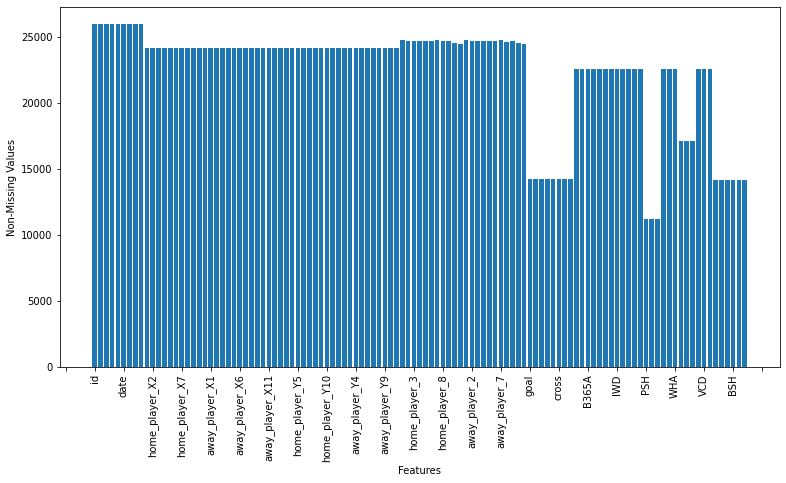

In [32]:
myLocator = mticker.MultipleLocator(5)
ser = match_df.count().tolist()
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
# langs = ['f' + str(i) for i in range(1,len(ser) + 1)]
langs = match_df.columns.values.tolist()
ax.bar(langs,ser)
ax.xaxis.set_major_locator(myLocator)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('Features')
ax.set_ylabel('Non-Missing Values')
plt.show()

### 3
Plot the target variables

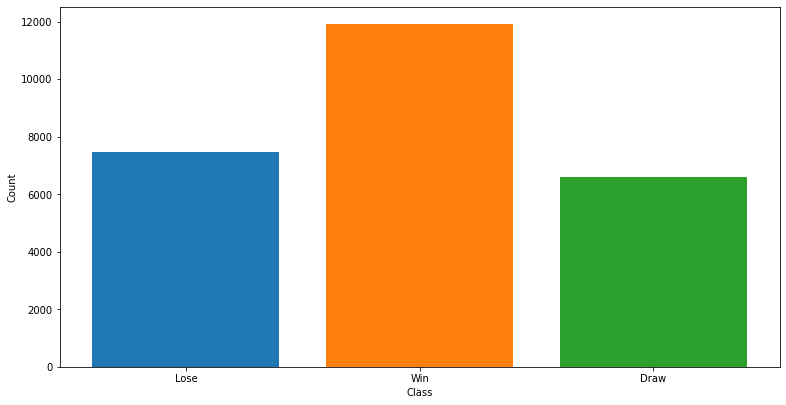

In [33]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
langs = {'Lose':0,'Win':1,'Draw':2}
for i,v in langs.items():
    sub = y[y == v]
    ax.bar(i,len(sub))
ax.set_ylabel('Count')
ax.set_xlabel('Class')
plt.show()

<div id="sc"></div>

##Data Pre-processing and Data Engineering

In [34]:
def OnlyNum(s):   
    fomart = '0123456789'   
    for c in s:   
        if (c in fomart) == False:   
             s = s.replace(c,'');   
    return s

def DelNans(match_df):
    to_drop = []
    for col in match_df.columns.tolist():
        num_nans = match_df[col].isna().sum()
        if num_nans / len(match_df[col]) >= 0.5:
            to_drop.append(col)
    if len(to_drop) >= 1:
        match_df = match_df.drop(to_drop, axis = 1)
    return match_df

# Deleteing NAs:
match_df = DelNans(match_df)
# Get players formation :
home_formation = {}
away_formation = {}


for index,row in match_df.iterrows():
    home_player_y = list()
    away_player_y = list()

    #create two list to store Y coordinate for each team
    
    for i in range(2,12):
        home_player_y.append(row['home_player_Y%d' % i])
        away_player_y.append(row['away_player_Y%d' % i])
    
    
    c_home = Counter(home_player_y)
    c_away = Counter(away_player_y)
    
    formation_home = Counter(sorted(c_home.elements())).values()
    
    formation_home = OnlyNum(str(formation_home))

    formation_away = Counter(sorted(c_away.elements())).values()
    formation_away = OnlyNum(str(formation_away))
    
    home_formation.update({row['match_api_id'] : formation_home})
    away_formation.update({row['match_api_id'] : formation_away})


match_df['home_formation'] = match_df['match_api_id'].map(home_formation)
match_df['away_formation'] = match_df['match_api_id'].map(away_formation)

match_df.drop(columns=['home_player_Y1','home_player_Y2','home_player_Y3','home_player_Y4','home_player_Y5','home_player_Y6','home_player_Y7','home_player_Y8','home_player_Y9','home_player_Y10','home_player_Y11'],inplace = True)
match_df.drop(columns=['away_player_Y1','away_player_Y2','away_player_Y3','away_player_Y4','away_player_Y5','away_player_Y6','away_player_Y7','away_player_Y8','away_player_Y9','away_player_Y10','away_player_Y11'],inplace = True)


# Dealing with missing values :
df_num = match_df.select_dtypes(include = np.float)
df_cat = match_df.select_dtypes(exclude = np.float).iloc[:,1:]

# Numeric First :
dc = df_num.copy()
floats_cols = []
for col in df_num.columns:
    no_nans = df_num[col].dropna()
    if all([True if i == round(i) else False for i in no_nans.tolist()]):
       continue
    else:
        dc[col].fillna(df_num[col].median(),inplace = True)

# Define KNN imputer
imputer = KNNImputer(n_neighbors=2)
X_numeric = pd.DataFrame(imputer.fit_transform(dc))

# Nominal : 
df_cat = df_cat.drop(['match_api_id'], axis = 1)
df_cat['home_team'] = [str(i) + str(j) for i,j in zip(df_cat['home_team_api_id'],df_cat['season'])]
df_cat['away_team'] = [str(i) + str(j) for i,j in zip(df_cat['away_team_api_id'],df_cat['season'])]     
df_cat = df_cat[['home_team','away_team','away_formation','home_formation']]
X_cat = pd.get_dummies(df_cat)
X = pd.concat([X_cat,X_numeric], axis = 1)


# Train Test Split :

X_train = X.iloc[TRAIN_idx,:]
y_train = y.iloc[TRAIN_idx]

X_test = X.iloc[TEST_idx,:]
y_test = y.iloc[TEST_idx]

**Dimensionality Reduction**

Explained Variance: 0.9999999999808578


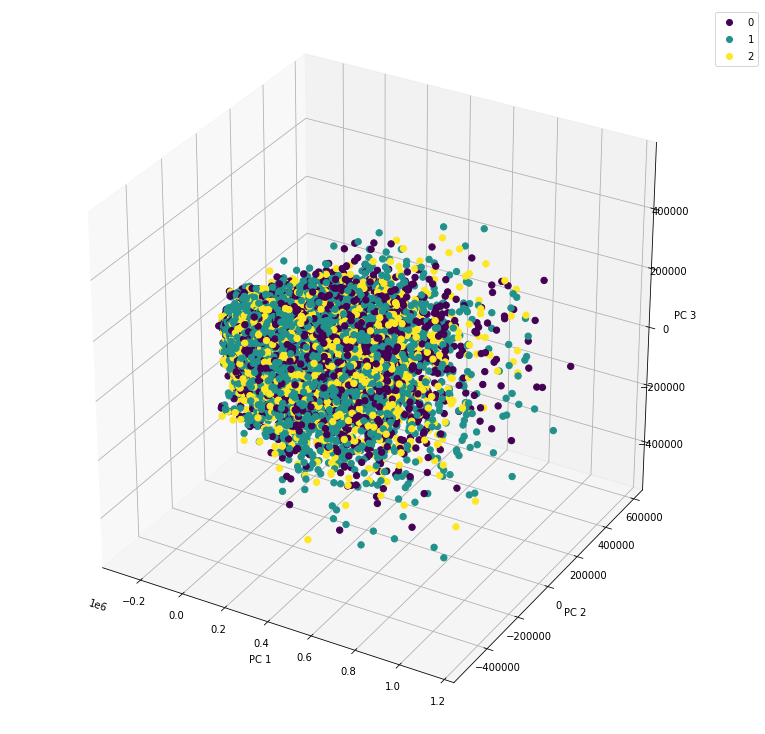

In [35]:
# Feature Selection :
pca = PCA(n_components=50)
fit = pca.fit(X_train)

# Summarize components
print("Explained Variance: %s" % np.sum(fit.explained_variance_ratio_))
X_train = pca.transform(X_train)



# PLOT PCA 
to_plot = pd.DataFrame(X_train[:,:3])
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

# plot
sc = ax.scatter(to_plot.iloc[:,0], to_plot.iloc[:,1], to_plot.iloc[:,2], s=40, c=y_train, marker='o', alpha=1)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

# Legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1))

<div id="sc"></div>

##Models Comparision

![](https://cdn-cf.cfo.com/content/uploads/2019/10/GettyImages-966248982-1024x659.jpg)

LDA: 0.518828 (0.019927)
CART: 0.402243 (0.020654)
GaussianNB: 0.469342 (0.029490)
RF: 0.508101 (0.024274)
XGB: 0.522977 (0.021081)
ADAB: 0.515031 (0.019125)


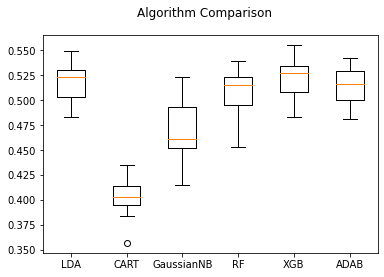

In [27]:
# MODELS :

models = []
#models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('GaussianNB', GaussianNB()))
models.append(('RF',RandomForestClassifier()))
models.append(('XGB', XGBClassifier()))
# models.append(('SVM', svm.SVC(kernel='linear')))# Linear Kernel)
models.append(('ADAB', AdaBoostClassifier(n_estimators=50,learning_rate=1)))
# models.append(('KMeans', KMeans(n_clusters=2, random_state=0)))

# Evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
 	kfold = model_selection.KFold(n_splits=10)
 	cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
 	results.append(cv_results)
 	names.append(name)
 	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
 	print(msg)
  
# Boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


**Models Evaluation**

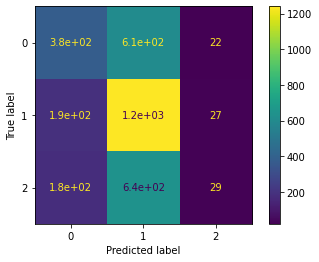

In [36]:
# TEST : Confusion Matrix 
X_test = pca.transform(X_test)    

chosen_model = XGBClassifier()
chosen_model.fit(X_train,y_train)
y_pred = chosen_model.predict(X_test)
score = chosen_model.score(X_test,y_test)

plm(chosen_model,X_test,y_test)